Using device: cuda
Unique labels after encoding: [1 0 2 3]
Train size: 133555, Validation size: 28625, Test size: 28621


/tmp/ipykernel_8669/1962453221.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['alti'].fillna(df['alti'].mean(), inplace=True)


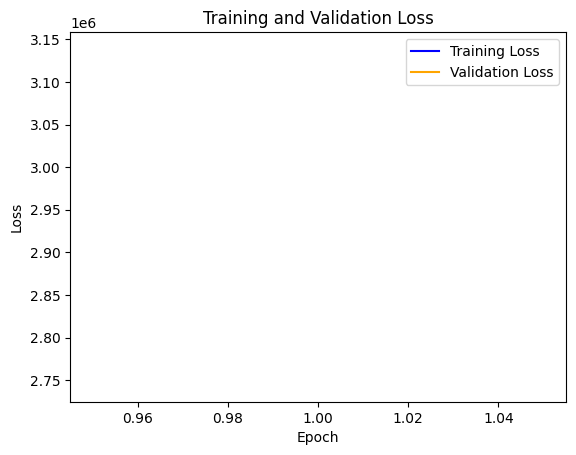

Epoch 1/100, Training Loss: 3138718.3349754433, Validation Loss: 2744373.6306501115
Epoch 2/100, Training Loss: 3119705.631558457, Validation Loss: 2761115.376325335
Epoch 3/100, Training Loss: 3110613.7100802585, Validation Loss: 2724928.170061384
Epoch 4/100, Training Loss: 3097280.323805103, Validation Loss: 2716756.4958147323
Epoch 5/100, Training Loss: 3089377.040428845, Validation Loss: 2709628.555733817
Epoch 6/100, Training Loss: 3085816.6826784858, Validation Loss: 2709603.701171875
Epoch 7/100, Training Loss: 3078099.639569358, Validation Loss: 2709437.834891183
Epoch 8/100, Training Loss: 3071403.0422107093, Validation Loss: 2699053.5167410714
Epoch 9/100, Training Loss: 3060557.979321394, Validation Loss: 2687028.6316964286
Epoch 10/100, Training Loss: 3054402.606372784, Validation Loss: 2697775.4617745536
Epoch 11/100, Training Loss: 3051016.8640243174, Validation Loss: 2698260.9820731026
Epoch 12/100, Training Loss: 3045144.795010781, Validation Loss: 2690617.6032366073
E

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
file_path = 'Flight_processed_data.xlsx'
df = pd.read_excel(file_path)

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'aircraftterminal' column
df['aircraftterminal'] = le.fit_transform(df['aircraftterminal'].astype(str))

# Verify encoding
print("Unique labels after encoding:", df['aircraftterminal'].unique())

df['alti'].fillna(df['alti'].mean(), inplace=True)

# Define features (X) and target (y)
X = df.drop(columns=['actual_difference_seconds'])  # Replace with your target column
y = df['actual_difference_seconds']

# Identify numerical and categorical columns
numerical_columns = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'feel', 'hour', 'minute', 'day_of_week', 'day_of_month', 'month', 'year']
categorical_columns = list(set(X.columns) - set(numerical_columns))

# Apply scaling only to numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X[numerical_columns])  # Scale only numerical columns

# Split data into train (70%), validation (15%), and test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 x 85% ≈ 15%

# Verify sizes
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# Convert data into PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# TimesNet Implementation (simplified for forecasting tasks)
class TimesNet(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(TimesNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model, loss, and optimizer
input_size = X_train.shape[1]  # Number of features
model = TimesNet(input_size).to(device)  # Move model to device
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize graph plotting
train_losses = []
val_losses = []

plt.ion()  # Turn on interactive mode for real-time updating
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')

# Training loop
epochs = 100  # Reduce epochs for demonstration
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Move data to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Update the graph
    ax.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    ax.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
    ax.legend()
    plt.pause(0.01)  # Pause to update the graph

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

plt.ioff()  # Turn off interactive mode
plt.show()  # Show the final plot

# Evaluate on the test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Move data to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

# Future Predictions
future_inputs = torch.tensor(X_test.values, dtype=torch.float32).to(device)  # Move to device
future_predictions = model(future_inputs).detach().cpu().numpy()  # Move back to CPU for further processing

print("Future Predictions:", future_predictions)

In [2]:
from sklearn.metrics import mean_absolute_error

# Ensure future_predictions and y_test are in the same format
y_test_array = y_test.values  # Convert y_test to a NumPy array if it's not already

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_array, future_predictions)

print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 832.8213245787131


In [4]:
file_path = r'difference_flight_updated1.xlsx'
df_true = pd.read_excel(file_path)

# Find the maximum value in the column
mean_value = df_true['estimated_difference_seconds'].mean()

# Fill NaN with the maximum value
df_true['estimated_difference_seconds'].fillna(mean_value, inplace=True)

# Verify that there are no more NaN values
print("Remaining NaN values:", df_true['estimated_difference_seconds'].isnull().sum())



Remaining NaN values: 0


/tmp/ipykernel_8669/21618688.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_true['estimated_difference_seconds'].fillna(mean_value, inplace=True)


In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming your DataFrame has columns for true and predicted values:
# 'actual_difference_seconds' = True target values
# 'estimated_difference_seconds' = Predicted values

# Calculate the starting index for the last 20%
n = len(df_true)  # Total number of rows
start_index = int(n * 0.8)  # Start of the last 20%

# Slice the last 20% of the DataFrame
actual_last_20 = df_true['actual_difference_seconds'].iloc[start_index:]
predicted_last_20 = df_true['estimated_difference_seconds'].iloc[start_index:]

# Calculate MAE for the last 20%
mae_last_20 = mean_absolute_error(actual_last_20, predicted_last_20)

print("Mean Absolute Error for the last 20%:", mae_last_20)


Mean Absolute Error for the last 20%: 1310.244522967336
